DRIVE MOUNT

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Augmentation**

In [3]:
# Augmentation
import os
import random
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Configuration ---
# Set the path to your dataset folder in Google Drive
base_dataset_path = '/content/drive/MyDrive/Thesis/dataset' # <-- IMPORTANT: Check this path is correct

# Define the folders for each class
class_folders = {
    'acne': 'acne',
    'hyperpigmentation': 'hyperpigmentation',
    'Nail_psoriasis': 'Nail_psoriasis',
    'SJS-TEN': 'SJS-TEN',
    'Vitiligo': 'Vitiligo' # <-- Double-check this name matches your folder exactly
}

# The target number of images per class
target_image_count = 2000

# --- Augmentation Setup ---
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# --- Main Loop ---
for class_name, folder_name in class_folders.items():
    folder_path = os.path.join(base_dataset_path, folder_name)

    # --- ⭐️ ERROR FIX: Check if the folder exists ---
    if not os.path.isdir(folder_path):
        print(f"🚨 ERROR: Directory not found for class '{class_name}': {folder_path}. Skipping.")
        continue

    # Get the list of all images in the folder
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    num_images = len(images)

    print(f"\nProcessing '{class_name}': Found {num_images} images.")

    # --- Logic to Increase, Decrease, or Skip ---
    if num_images < target_image_count:
        # --- AUGMENTATION (INCREASE) LOGIC ---
        num_to_generate = target_image_count - num_images
        print(f"Augmenting '{class_name}': Generating {num_to_generate} new images...")

        # Select random images from the folder to augment
        images_to_augment = random.choices(images, k=num_to_generate)

        for image_name in images_to_augment:
            image_path = os.path.join(folder_path, image_name)
            try:
                img = Image.open(image_path).convert('RGB')
                img = img.resize((224, 224))
                x = np.array(img)
                x = x.reshape((1,) + x.shape)

                # Generate one augmented image
                for batch in datagen.flow(x, batch_size=1):
                    augmented_image = Image.fromarray(batch[0].astype('uint8'))
                    new_image_name = f"aug_{random.randint(10000, 99999)}_{image_name}"
                    augmented_image.save(os.path.join(folder_path, new_image_name))
                    break # Stop after one is generated
            except Exception as e:
                print(f"Could not process image {image_name}. Error: {e}")

    elif num_images > target_image_count:
        # --- ⭐️ NEW: DECREASE LOGIC ---
        num_to_delete = num_images - target_image_count
        print(f"Decreasing '{class_name}': Randomly deleting {num_to_delete} images...")

        # Randomly select images to delete
        images_to_delete = random.sample(images, num_to_delete)

        for image_name in images_to_delete:
            file_to_delete_path = os.path.join(folder_path, image_name)
            try:
                os.remove(file_to_delete_path)
            except Exception as e:
                print(f"Could not delete image {image_name}. Error: {e}")

    else: # num_images == target_image_count
        print(f"'{class_name}' already has {target_image_count} images. No action needed.")


print("\nProcessing complete! ✅")



Processing 'acne': Found 1148 images.
Augmenting 'acne': Generating 852 new images...

Processing 'hyperpigmentation': Found 292 images.
Augmenting 'hyperpigmentation': Generating 1708 new images...

Processing 'Nail_psoriasis': Found 2520 images.
Decreasing 'Nail_psoriasis': Randomly deleting 520 images...

Processing 'SJS-TEN': Found 3164 images.
Decreasing 'SJS-TEN': Randomly deleting 1164 images...

Processing 'Vitiligo': Found 2016 images.
Decreasing 'Vitiligo': Randomly deleting 16 images...

Processing complete! ✅


**Splitting**

In [3]:
import os
import random
import shutil

# --- Configuration ---
# Path to your balanced dataset (where each class has 2000 images)
source_dataset_path = '/content/drive/MyDrive/Thesis/dataset' # <-- IMPORTANT: Path to your processed dataset

# Path where the new split dataset will be created
output_dataset_path = '/content/drive/MyDrive/Thesis/Split_dataset'

# Define the split ratios
# 70% for training, 15% for validation, 15% for testing
split_ratios = (0.7, 0.15, 0.15)

# --- Main Splitting Logic ---
print("Starting dataset split...")

# Create the main output directories (train, validation, test)
if os.path.exists(output_dataset_path):
    shutil.rmtree(output_dataset_path) # Remove old directory to ensure a clean split
    print(f"Removed existing directory at: {output_dataset_path}")

train_dir = os.path.join(output_dataset_path, 'train')
validation_dir = os.path.join(output_dataset_path, 'validation')
test_dir = os.path.join(output_dataset_path, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get the list of class folders from the source directory
class_names = [d for d in os.listdir(source_dataset_path) if os.path.isdir(os.path.join(source_dataset_path, d))]

# Loop through each class folder
for class_name in class_names:
    print(f"\nProcessing class: {class_name}")

    # Create class-specific subdirectories in train, validation, and test folders
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get all image file names for the current class
    source_class_dir = os.path.join(source_dataset_path, class_name)
    all_files = [f for f in os.listdir(source_class_dir) if os.path.isfile(os.path.join(source_class_dir, f))]

    # Shuffle the files randomly for an unbiased split
    random.shuffle(all_files)

    # Calculate split indices
    total_files = len(all_files)
    train_end = int(total_files * split_ratios[0])
    validation_end = train_end + int(total_files * split_ratios[1])

    # Slice the list of files into the three sets
    train_files = all_files[:train_end]
    validation_files = all_files[train_end:validation_end]
    test_files = all_files[validation_end:]

    # --- Function to copy files ---
    def copy_files(files, source_dir, dest_dir):
        for f in files:
            shutil.copy(os.path.join(source_dir, f), os.path.join(dest_dir, f))

    # Copy files to their new destination
    copy_files(train_files, source_class_dir, os.path.join(train_dir, class_name))
    copy_files(validation_files, source_class_dir, os.path.join(validation_dir, class_name))
    copy_files(test_files, source_class_dir, os.path.join(test_dir, class_name))

    print(f"  - Training set:   {len(train_files)} images")
    print(f"  - Validation set: {len(validation_files)} images")
    print(f"  - Testing set:    {len(test_files)} images")

print("\nDataset splitting complete! ✅")


Starting dataset split...

Processing class: hyperpigmentation
  - Training set:   1399 images
  - Validation set: 299 images
  - Testing set:    301 images

Processing class: acne
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: Nail_psoriasis
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: SJS-TEN
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: Vitiligo
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Dataset splitting complete! ✅


**Copying**

In [6]:
import os
import shutil
from tqdm import tqdm

# Path to your dataset on Google Drive
drive_dataset_path = "/content/drive/MyDrive/Thesis/Split_dataset"
# Path where you want to copy locally (Colab's fast storage)
local_dataset_path = "/content/dataset/Split_Dataset"

# Remove any old copy if exists
if os.path.exists(local_dataset_path):
    shutil.rmtree(local_dataset_path)

# Copy dataset from Drive to Colab local storage
print("Copying dataset from Drive to local storage...")
shutil.copytree(drive_dataset_path, local_dataset_path)

print("✅ Dataset copied to:", local_dataset_path)

Copying dataset from Drive to local storage...
✅ Dataset copied to: /content/dataset/Split_Dataset


**Resnet 50 and inception v3**

Found 6999 images belonging to 5 classes.
Found 6999 images belonging to 5 classes.
Found 1499 images belonging to 5 classes.
Found 1499 images belonging to 5 classes.
Found 5 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

--- Starting Initial Training (Training Ensemble Head) ---
Epoch 1/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 143s 949ms/step - accuracy: 0.6597 - loss: 1.2678 - val_accuracy: 0.9226 - val_loss: 0.2541
Epoch 2/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 60s 546ms/step - accuracy: 0.9086 - loss: 0.2729 - val_accuracy: 0.9293 - val_loss: 0.2007
Epoch 3/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 59s 541ms/step - accuracy: 0.9277 - loss: 0.2004 - val_accuracy: 0.9533 - val_loss: 0.1300
Epoch 4/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 57s 522ms/step - accuracy: 0.9458 - loss: 0.1434 - val_accuracy: 0.9553 - val_loss: 0.1256
Epoch 5/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 55s 507ms/step - accuracy: 0.9559 - loss: 0.1340 - val_accuracy: 0.9673 - val_loss: 0.0978
Epoch 6/8
110/110 ━━━━━━━━━━━━━━━━━━━━ 75s 686ms/step

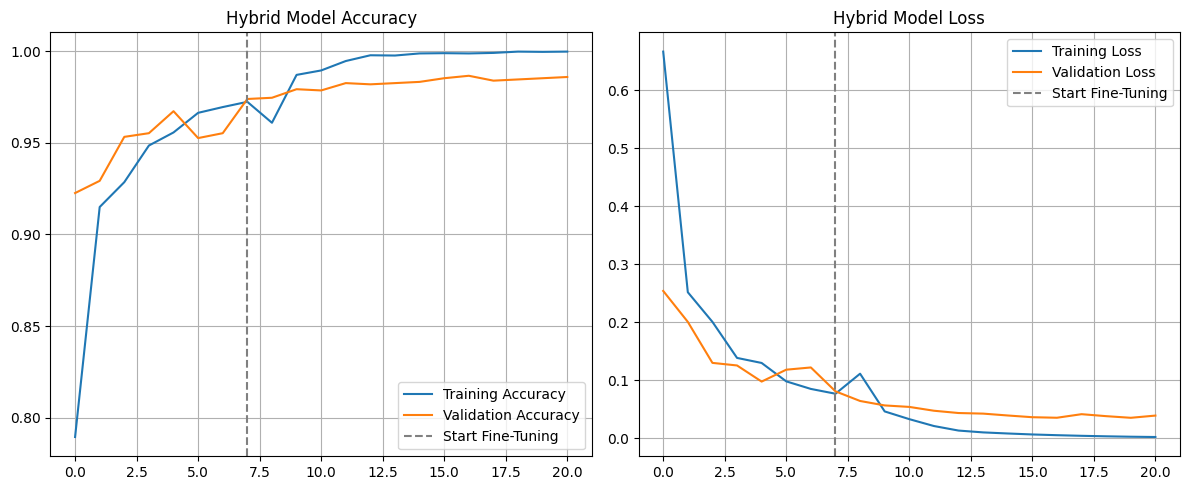



--- Starting Final Evaluation on Test Data ---
Found 1501 images belonging to 5 classes.
Found 1501 images belonging to 5 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9922 - loss: 0.0295

Overall Test Accuracy: 99.13%
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 942ms/step

## Classification Report ##

                   precision    recall  f1-score   support

   Nail_psoriasis       0.57      0.57      0.57       300
          SJS-TEN       0.57      0.58      0.58       300
         Vitiligo       0.57      0.57      0.57       300
             acne       0.57      0.57      0.57       300
hyperpigmentation       0.57      0.57      0.57       301

         accuracy                           0.57      1501
        macro avg       0.57      0.57      0.57      1501
     weighted avg       0.57      0.57      0.57      1501


## Confusion Matrix ##



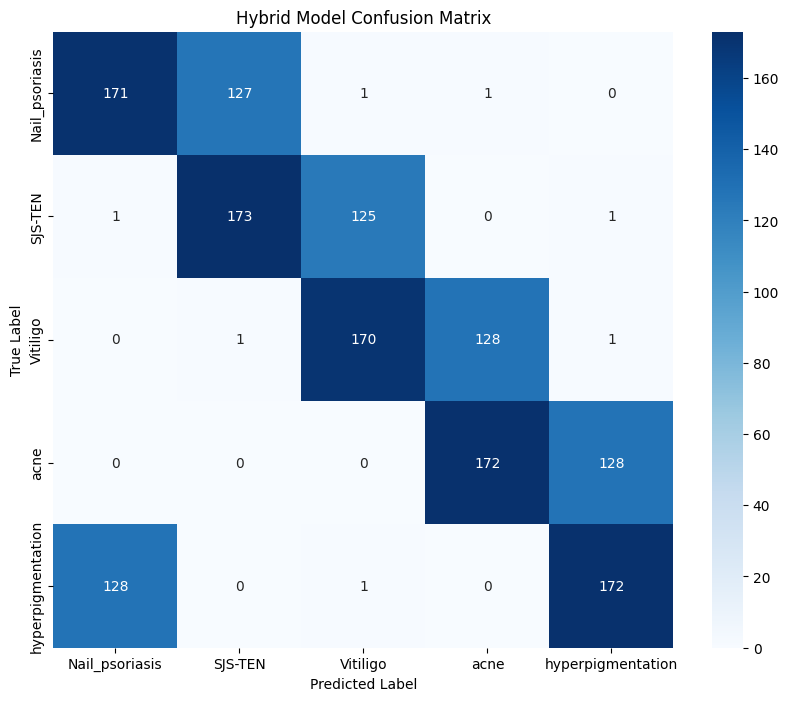



--- Starting XAI Analysis with Grad-CAM ---
--- Created float32 version of the Hybrid model for XAI. ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Hybrid model prediction for XAI image: hyperpigmentation

--- Generating Grad-CAM for ResNet50 branch ---


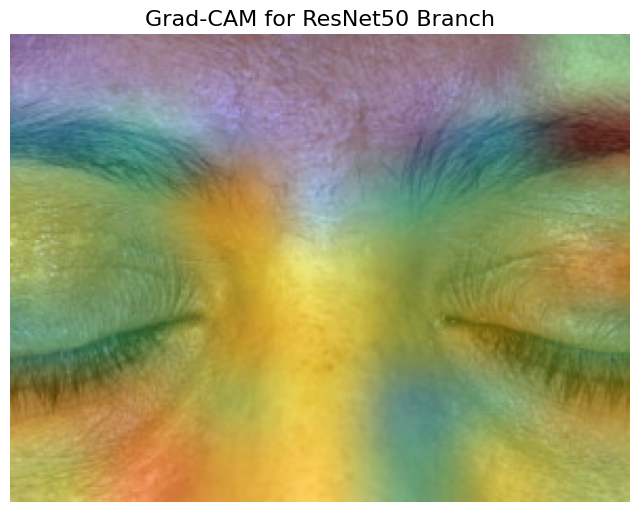


--- Generating Grad-CAM for InceptionV3 branch ---


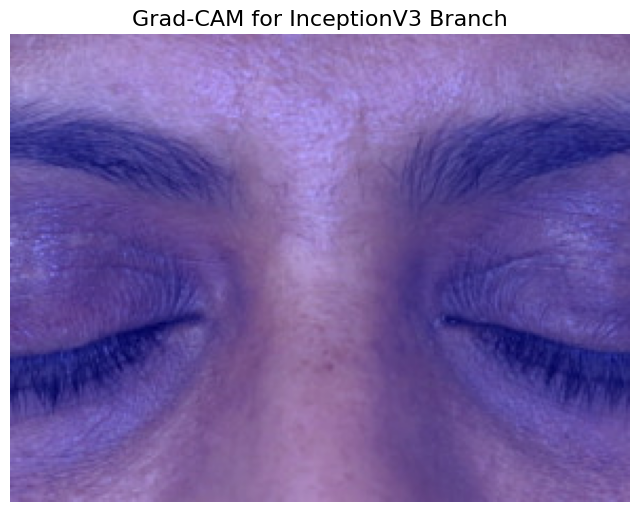


--- XAI analysis complete. Images saved in 'xai_results_hybrid' directory. ---


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2 # For XAI image processing

# --- 1. SETUP & CONFIGURATION ---
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Set paths to your dataset
base_dir = '/content/dataset/Split_Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Model parameters
IMG_SIZE_224 = 224
IMG_SIZE_299 = 299
BATCH_SIZE = 64
INITIAL_EPOCHS = 8
FINE_TUNE_EPOCHS = 12
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# --- 2. OPTIMIZED Data Pipeline ---
train_datagen_224 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
train_datagen_299 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
val_datagen_224 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
val_datagen_299 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_flow_224 = train_datagen_224.flow_from_directory(
    train_dir, target_size=(IMG_SIZE_224, IMG_SIZE_224), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=True)
train_flow_299 = train_datagen_299.flow_from_directory(
    train_dir, target_size=(IMG_SIZE_299, IMG_SIZE_299), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=True)
val_flow_224 = val_datagen_224.flow_from_directory(
    validation_dir, target_size=(IMG_SIZE_224, IMG_SIZE_224), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)
val_flow_299 = val_datagen_299.flow_from_directory(
    validation_dir, target_size=(IMG_SIZE_299, IMG_SIZE_299), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)

def multi_input_generator(gen224, gen299):
    while True:
        X1, y1 = next(gen224)
        X2, y2 = next(gen299)
        yield (X1, X2), y1

output_signature = (
    (tf.TensorSpec(shape=(None, IMG_SIZE_224, IMG_SIZE_224, 3), dtype=tf.float16),
     tf.TensorSpec(shape=(None, IMG_SIZE_299, IMG_SIZE_299, 3), dtype=tf.float16)),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: multi_input_generator(train_flow_224, train_flow_299),
    output_signature=output_signature).prefetch(tf.data.AUTOTUNE)
validation_dataset = tf.data.Dataset.from_generator(
    lambda: multi_input_generator(val_flow_224, val_flow_299),
    output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

num_classes = train_flow_224.num_classes
print(f"Found {num_classes} classes.")

# --- 3. Building the Hybrid Model ---
def create_hybrid_model(num_classes):
    input_224 = Input(shape=(IMG_SIZE_224, IMG_SIZE_224, 3), name='input_224')
    input_299 = Input(shape=(IMG_SIZE_299, IMG_SIZE_299, 3), name='input_299')

    resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_224, name='resnet50')
    resnet_base.trainable = False

    inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_299, name='inception_v3')
    inception_base.trainable = False

    out_resnet = GlobalAveragePooling2D(name='gap_resnet')(resnet_base.output)
    out_inception = GlobalAveragePooling2D(name='gap_inception')(inception_base.output)

    concat_features = Concatenate(name='concat_features')([out_resnet, out_inception])
    ensemble_dense_1 = Dense(512, activation='relu', name='ensemble_dense_1')(concat_features)
    ensemble_dropout_1 = Dropout(0.5, name='ensemble_dropout_1')(ensemble_dense_1)
    final_predictions = Dense(num_classes, activation='softmax', dtype='float32', name='final_predictions')(ensemble_dropout_1)

    model = Model(inputs=[input_224, input_299], outputs=final_predictions, name="Hybrid_ResNet_Inception")
    return model, [resnet_base, inception_base]

hybrid_model, base_models = create_hybrid_model(num_classes)

# --- 4. Compile and Train (Feature Extraction) ---
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.001))
hybrid_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n--- Starting Initial Training (Training Ensemble Head) ---")
history = hybrid_model.fit(
    train_dataset,
    steps_per_epoch=len(train_flow_224),
    epochs=INITIAL_EPOCHS,
    validation_data=validation_dataset,
    validation_steps=len(val_flow_224)
)

# --- 5. Fine-Tuning Phase ---
print("\n--- Starting Fine-Tuning (ResNet50 & InceptionV3) ---")
for base_model in base_models:
    base_model.trainable = True
    if 'resnet' in base_model.name: fine_tune_at = 143
    else: fine_tune_at = 249
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

optimizer_fine = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate=1e-5))
hybrid_model.compile(optimizer=optimizer_fine, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_fine = hybrid_model.fit(
    train_dataset,
    steps_per_epoch=len(train_flow_224),
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
    validation_steps=len(val_flow_224)
)

# --- 6. Plotting Training History ---
print("\n--- Plotting Training and Validation History ---")
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Hybrid Model Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Hybrid Model Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 7. FINAL EVALUATION ON TEST SET ---
print("\n\n--- Starting Final Evaluation on Test Data ---")
test_datagen_224 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
test_datagen_299 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
test_flow_224 = test_datagen_224.flow_from_directory(test_dir, target_size=(IMG_SIZE_224, IMG_SIZE_224), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)
test_flow_299 = test_datagen_299.flow_from_directory(test_dir, target_size=(IMG_SIZE_299, IMG_SIZE_299), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)
test_dataset = tf.data.Dataset.from_generator(lambda: multi_input_generator(test_flow_224, test_flow_299), output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

test_steps = len(test_flow_224)
test_loss, test_accuracy = hybrid_model.evaluate(test_dataset, steps=test_steps)
print(f"\nOverall Test Accuracy: {test_accuracy*100:.2f}%")

y_pred_probs = hybrid_model.predict(test_dataset, steps=test_steps)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_flow_224.classes
class_indices = test_flow_224.class_indices
sorted_indices = sorted(class_indices.items(), key=lambda item: item[1])
correctly_ordered_class_names = [item[0] for item in sorted_indices]
y_pred = y_pred[:len(y_true)]

print("\n## Classification Report ##\n")
print(classification_report(y_true, y_pred, target_names=correctly_ordered_class_names))

print("\n## Confusion Matrix ##\n")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=correctly_ordered_class_names, yticklabels=correctly_ordered_class_names)
plt.title('Hybrid Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# --- 8. EXPLAINABLE AI (XAI) WITH GRAD-CAM ---
print("\n\n--- Starting XAI Analysis with Grad-CAM ---")

# ⭐️ FIX: Full function bodies are now included
def get_grad_cam_heatmap(img_array, grad_model, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, logits = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(logits[0])
        class_channel = logits[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

def superimpose_grad_cam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    return superimposed_img

def create_hybrid_model_float32(num_classes):
    input_224 = Input(shape=(IMG_SIZE_224, IMG_SIZE_224, 3), name='input_224', dtype=tf.float32)
    input_299 = Input(shape=(IMG_SIZE_299, IMG_SIZE_299, 3), name='input_299', dtype=tf.float32)
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_224, name='resnet50')
    inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_299, name='inception_v3')
    out_resnet = GlobalAveragePooling2D(name='gap_resnet')(resnet_base.output)
    out_inception = GlobalAveragePooling2D(name='gap_inception')(inception_base.output)
    concat_features = Concatenate(name='concat_features')([out_resnet, out_inception])
    ensemble_dense_1 = Dense(512, activation='relu', name='ensemble_dense_1')(concat_features)
    ensemble_dropout_1 = Dropout(0.5, name='ensemble_dropout_1')(ensemble_dense_1)
    final_predictions = Dense(num_classes, activation='softmax', name='final_predictions')(ensemble_dropout_1)
    model = Model(inputs=[input_224, input_299], outputs=final_predictions, name="Hybrid_Float32")
    return model

hybrid_model_float32 = create_hybrid_model_float32(num_classes)
hybrid_model_float32.set_weights(hybrid_model.get_weights())
print("--- Created float32 version of the Hybrid model for XAI. ---")

# ⭐️ IMPORTANT: Specify the path to an image from your test set for explanation
IMAGE_PATH_FOR_XAI = '/content/dataset/Split_Dataset/test/hyperpigmentation/acquired-dermal-macular-hyperpigmentation-001__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDExMl0.jpeg' # <-- CHANGE THIS
os.makedirs("xai_results_hybrid", exist_ok=True)
original_img = cv2.imread(IMAGE_PATH_FOR_XAI)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Preprocess the image for XAI
img_224 = tf.keras.utils.load_img(IMAGE_PATH_FOR_XAI, target_size=(224, 224))
img_array_224 = np.expand_dims(tf.keras.utils.img_to_array(img_224), axis=0)
preprocessed_224 = tf.keras.applications.resnet50.preprocess_input(img_array_224.copy())
img_299 = tf.keras.utils.load_img(IMAGE_PATH_FOR_XAI, target_size=(299, 299))
img_array_299 = np.expand_dims(tf.keras.utils.img_to_array(img_299), axis=0)
preprocessed_299 = tf.keras.applications.inception_v3.preprocess_input(img_array_299.copy())

preds = hybrid_model_float32.predict([preprocessed_224, preprocessed_299])
top_pred_index = np.argmax(preds[0])
print(f"Hybrid model prediction for XAI image: {correctly_ordered_class_names[top_pred_index]}")

# Generate heatmaps
last_conv_layer_names = {"ResNet50": "conv5_block3_out", "InceptionV3": "mixed10"}
final_logit_layer = hybrid_model_float32.get_layer('ensemble_dropout_1').output

for model_name, layer_name in last_conv_layer_names.items():
    print(f"\n--- Generating Grad-CAM for {model_name} branch ---")
    grad_model = tf.keras.models.Model(
        hybrid_model_float32.inputs,
        [hybrid_model_float32.get_layer(layer_name).output, final_logit_layer]
    )
    input_array = [preprocessed_224, preprocessed_299]
    heatmap = get_grad_cam_heatmap(input_array, grad_model, pred_index=top_pred_index)
    superimposed_image = superimpose_grad_cam(original_img, heatmap)
    save_path = os.path.join("xai_results_hybrid", f"grad_cam_{model_name}.png")
    superimposed_image.save(save_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_image)
    plt.title(f"Grad-CAM for {model_name} Branch", fontsize=16)
    plt.axis("off")
    plt.show()

print("\n--- XAI analysis complete. Images saved in 'xai_results_hybrid' directory. ---")

Found 1501 images belonging to 5 classes.
Found 1501 images belonging to 5 classes.

--- Generating predictions on the test set... ---
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 376ms/step

Keras Class Mapping: {'Nail_psoriasis': 0, 'SJS-TEN': 1, 'Vitiligo': 2, 'acne': 3, 'hyperpigmentation': 4}
Correctly Ordered Labels for Report: ['Nail_psoriasis', 'SJS-TEN', 'Vitiligo', 'acne', 'hyperpigmentation']

## Classification Report (Corrected) ##

                   precision    recall  f1-score   support

   Nail_psoriasis       1.00      1.00      1.00       300
          SJS-TEN       0.98      0.99      0.99       300
         Vitiligo       0.99      0.98      0.98       300
             acne       0.99      1.00      1.00       300
hyperpigmentation       0.99      1.00      1.00       301

         accuracy                           0.99      1501
        macro avg       0.99      0.99      0.99      1501
     weighted avg       0.99      0.99      0.99      1501


## Confusion Matrix (Corrected

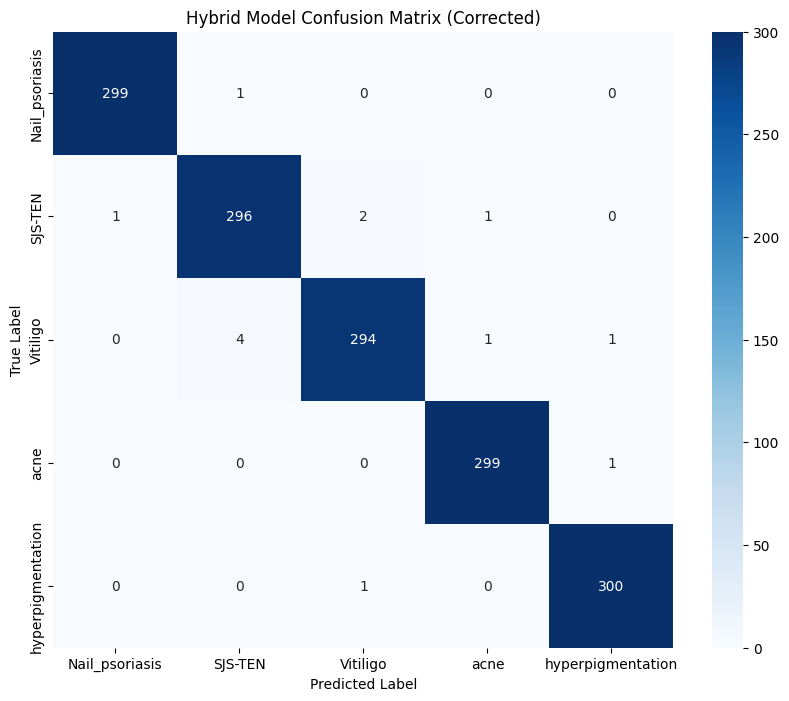

In [11]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os

# --- 1. Configuration and Test Data Pipeline Setup ---
# This section re-creates the data pipeline for your specific hybrid model.

# Set path to your dataset (ensure this is correct)
base_dir = '/content/dataset/Split_Dataset'
test_dir = os.path.join(base_dir, 'test')

# Model parameters (must match your training script)
IMG_SIZE_224 = 224
IMG_SIZE_299 = 299
BATCH_SIZE = 32 # Use the same batch size as training

# Create two separate data flows for the two required image sizes
# shuffle=False is critical for correct evaluation
test_datagen_224 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
test_datagen_299 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

test_flow_224 = test_datagen_224.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE_224, IMG_SIZE_224),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False)

test_flow_299 = test_datagen_299.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE_299, IMG_SIZE_299),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False)

# Custom Python generator that yields the multi-input data
def multi_input_generator(gen224, gen299):
    while True:
        X1, y1 = next(gen224)
        X2, y2 = next(gen299)
        yield (X1, X2), y1

# Define the data signature for TensorFlow
# Use float32 for evaluation as mixed precision policy is not set here
output_signature = (
    (tf.TensorSpec(shape=(None, IMG_SIZE_224, IMG_SIZE_224, 3), dtype=tf.float32),
     tf.TensorSpec(shape=(None, IMG_SIZE_299, IMG_SIZE_299, 3), dtype=tf.float32)),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

# Convert the Python generator into an optimized tf.data.Dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: multi_input_generator(test_flow_224, test_flow_299),
    output_signature=output_signature
).prefetch(tf.data.AUTOTUNE)


# --- 2. Get Model Predictions ---
print("\n--- Generating predictions on the test set... ---")

# Calculate the number of steps needed to cover the entire test set
test_steps = len(test_flow_224)

# Get predictions from the trained hybrid_model
y_pred_probs = hybrid_model.predict(test_dataset, steps=test_steps)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the true labels
y_true = test_flow_224.classes

# Ensure prediction array has the correct length
y_pred = y_pred[:len(y_true)]


# --- 3. THE FIX: Create Correctly Ordered Class Labels ---
# This step prevents the cyclical error in the confusion matrix by ensuring
# the label names match the integer indices (0, 1, 2...).

class_indices = test_flow_224.class_indices
# Sort the dictionary by its integer value
sorted_indices = sorted(class_indices.items(), key=lambda item: item[1])
# Create a new list of names in the correct order
correctly_ordered_class_names = [item[0] for item in sorted_indices]

print("\nKeras Class Mapping:", class_indices)
print("Correctly Ordered Labels for Report:", correctly_ordered_class_names)


# --- 4. Display Correct Evaluation Metrics ---

# Generate and print the classification report using the corrected names
print("\n## Classification Report (Corrected) ##\n")
print(classification_report(y_true, y_pred, target_names=correctly_ordered_class_names))

# Generate and plot the confusion matrix using the corrected names
print("\n## Confusion Matrix (Corrected) ##\n")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=correctly_ordered_class_names,
            yticklabels=correctly_ordered_class_names)
plt.title('Hybrid Model Confusion Matrix (Corrected)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()